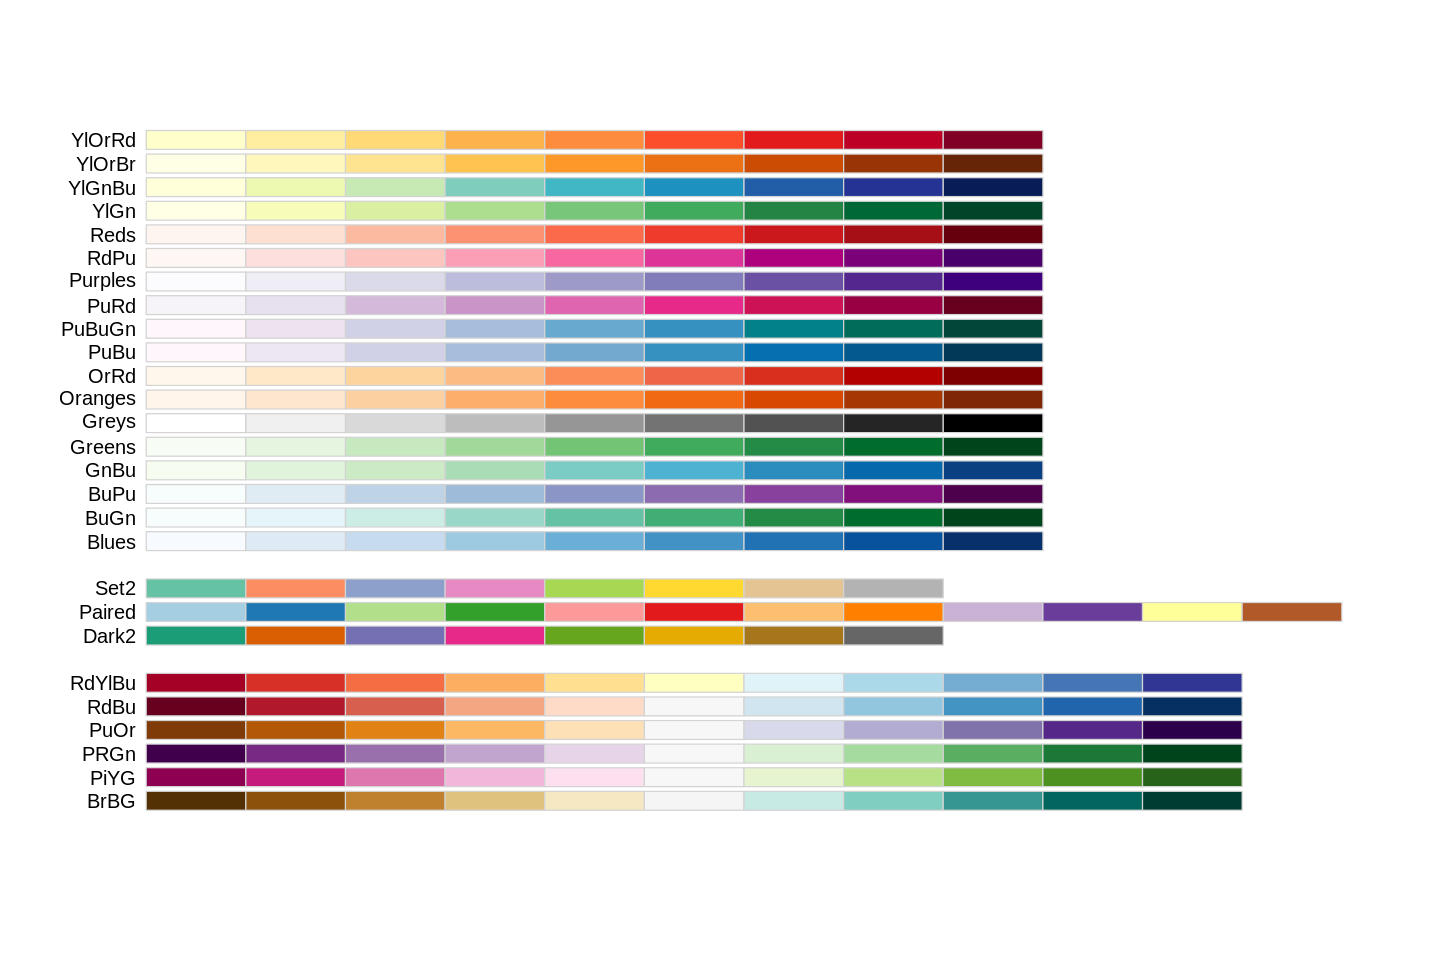

In [28]:
library(tidyverse)
library(repr)
library(tidymodels)
library(scales)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)
# Ensure the Palette used is colour blind friendly
display.brewer.all(colorblindFriendly = TRUE)

Parsed with column specification:
cols(
  Sector_score = col_double(),
  LOCATION_ID = col_character(),
  PARA_A = col_double(),
  SCORE_A = col_double(),
  PARA_B = col_double(),
  SCORE_B = col_double(),
  TOTAL = col_double(),
  numbers = col_double(),
  Marks = col_double(),
  Money_Value = col_double(),
  MONEY_Marks = col_double(),
  District = col_double(),
  Loss = col_double(),
  LOSS_SCORE = col_double(),
  History = col_double(),
  History_score = col_double(),
  Score = col_double(),
  Risk = col_double()
)

`summarise()` ungrouping output (override with `.groups` argument)



Risk,count,percentage
<fct>,<int>,<dbl>
Fraud,486,62.62887
No Fraud,290,37.37113


Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


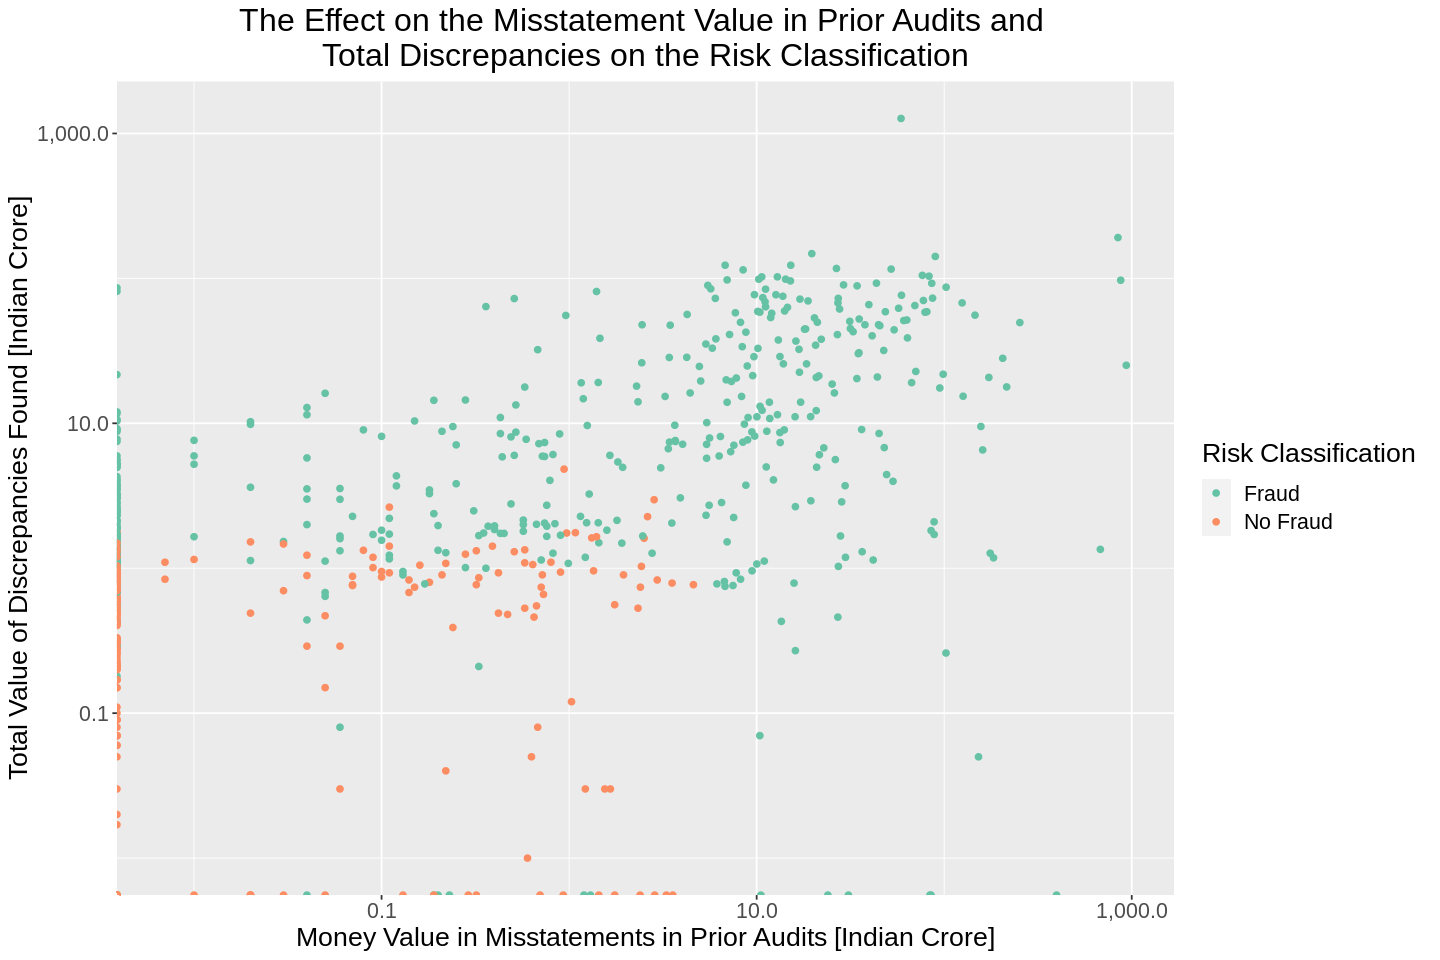

In [9]:
# Set seed to ensure randomness
set.seed(1001)

# Loading the Dataset
url = "https://raw.githubusercontent.com/fulleraltamiranoe/audit_data/main/trial.csv"
audit_trial_data <- read_csv(url) 

# Changing the Risk Classification to meaningful names
audit_trial_data$Risk <- ifelse(audit_trial_data$Risk == "1", "Fraud", "No Fraud")

# Treat Risk as factor
audit_trial_data <- audit_trial_data %>%
    mutate(Risk = as_factor(Risk))

# Group by Risk and Summarize to see how the Risk classification is ditributed
count <- audit_trial_data %>%
    group_by(Risk) %>%
    summarize(count = n(), percentage = n() / nrow(audit_trial_data) * 100)
count

# Visualizing original data utilizing a log scale
options(repr.plot.width = 12, repr.plot.height = 8) 
audit_original_plot <- audit_trial_data %>%
    ggplot(aes(x = Money_Value, y = TOTAL, colour = Risk)) +
    geom_point() +
    labs(x = "Money Value in Misstatements in Prior Audits [Indian Crore]", 
         y = "Total Value of Discrepancies Found [Indian Crore]", 
         colour = "Risk Classification") +
    ggtitle("The Effect on the Misstatement Value in Prior Audits and \nTotal Discrepancies on the Risk Classification") +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5)) +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) +
    scale_color_brewer(palette = "Set2")
audit_original_plot

In [10]:
# Cleaning the dataset and keeping predictors we will use
# From the above visualization, we can see that most firms
# are considered Fraud, we will balance the data set
audit <- audit_trial_data %>%
    select(Money_Value, TOTAL, Risk)
audit

# showcasing inbalance
count <- audit %>%
    group_by(Risk) %>%
    summarize(count = n(), percentage = n() / nrow(audit_trial_data) * 100)
count

# As mentioned above, Fraud data is over represented. Balancing original data
audit_recipe_balance <- recipe(Risk ~ TOTAL + Money_Value, data = audit) %>%
    step_upsample(Risk, over_ratio = 1, skip = FALSE) %>%
    prep()

# Balanced data
upsampled_audit <- bake(audit_recipe_balance, audit)


upsampled_count <- upsampled_audit %>%
    group_by(Risk) %>%
    summarize(count = n(), percentage = n() / nrow(audit_trial_data) * 100)
upsampled_count

Money_Value,TOTAL,Risk
<dbl>,<dbl>,<fct>
3.38,6.68,Fraud
0.94,4.83,No Fraud
0.00,0.74,No Fraud
⋮,⋮,⋮
0.00,0.28,No Fraud
0.00,0.20,No Fraud
0.32,0.00,No Fraud


`summarise()` ungrouping output (override with `.groups` argument)



Risk,count,percentage
<fct>,<int>,<dbl>
Fraud,486,62.62887
No Fraud,290,37.37113


`summarise()` ungrouping output (override with `.groups` argument)



Risk,count,percentage
<fct>,<int>,<dbl>
Fraud,486,62.62887
No Fraud,486,62.62887


x Fold1: model 1/1 (predictions): Error: Problem with `mutate()` input `.row`.
[...

x Fold2: model 1/1 (predictions): Error: Problem with `mutate()` input `.row`.
[...



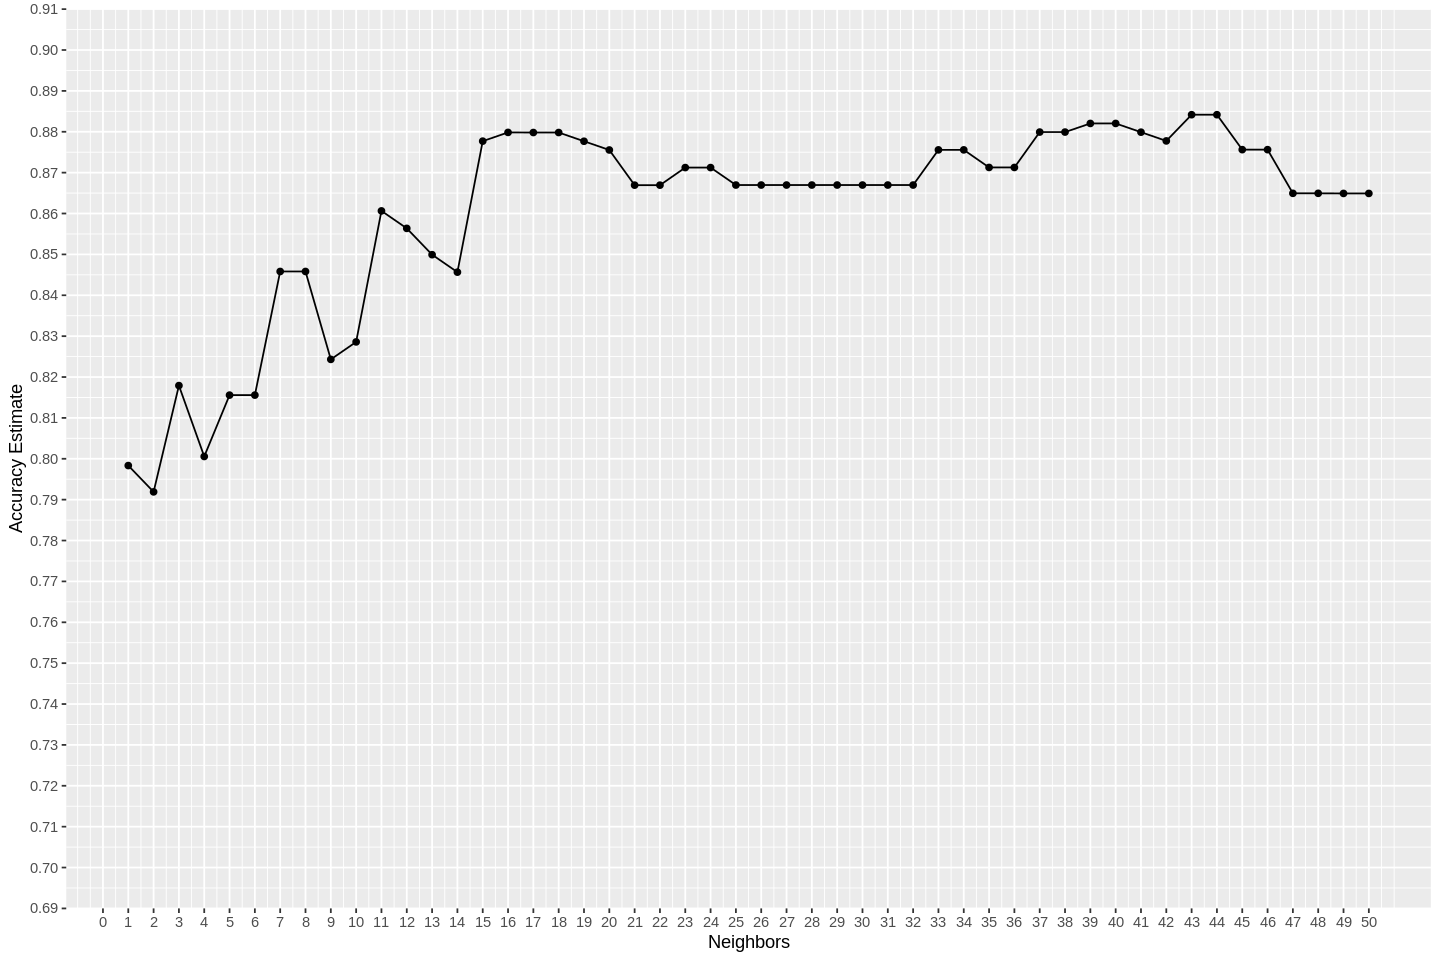

In [11]:
# Splitting data into training and testing sets, 80% training data to ensure as much accuracy in 
# our model as possible.
audit_split <- initial_split(upsampled_audit, prop = 0.8, strata = Risk)  
audit_train <- training(audit_split)   
audit_test <- testing(audit_split)

# Training with our predictors
audit_recipe <- recipe(Risk ~ TOTAL + Money_Value, data = audit_train) %>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())

# tuning, determine how many neighbours to use
knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
    set_engine('kknn') %>%
    set_mode('classification')

audit_vfold <- vfold_cv(audit_train, v = 5, strata = Risk)

# Multiple maximum values of K were tested, after 50 running the code takes too long and 
# there's no significant increase in accuracy
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_results <- workflow() %>%
    add_recipe(audit_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = audit_vfold, grid = k_vals) %>%
    collect_metrics()

accuracies <- knn_results %>% 
    filter(.metric == 'accuracy')

# Visualizing the accuracy of each value of K to choose the best possibe one
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    scale_x_continuous(limits = c(1, 50), breaks = seq(0, 50, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.7, 0.9), breaks = seq(0, 1, by = 0.01)) # adjusting the y-axis

accuracy_versus_k 

In [12]:
# K = 43 seems to be the most accurate, re-train with this value of K
audit_knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 43) %>%
    set_engine('kknn') %>%
    set_mode('classification')

# Fitting our data
audit_fit <- workflow() %>%
    add_recipe(audit_recipe) %>%
    add_model(audit_knn_spec) %>%
    fit(data = audit_train)

# Testing the accuracy of our model with our testing data 
audit_test_predictions <- predict(audit_fit, audit_test) %>%
    bind_cols(audit_test)

predictions_accuracy <- audit_test_predictions %>%
    metrics(truth = Risk, estimate = .pred_class)             
predictions_accuracy

# Creating a confusion matrix
audit_mat <- audit_test_predictions %>% 
    conf_mat(truth = Risk, estimate = .pred_class)   
audit_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9072165
kap,binary,0.8144330


          Truth
Prediction Fraud No Fraud
  Fraud       90       11
  No Fraud     7       86

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


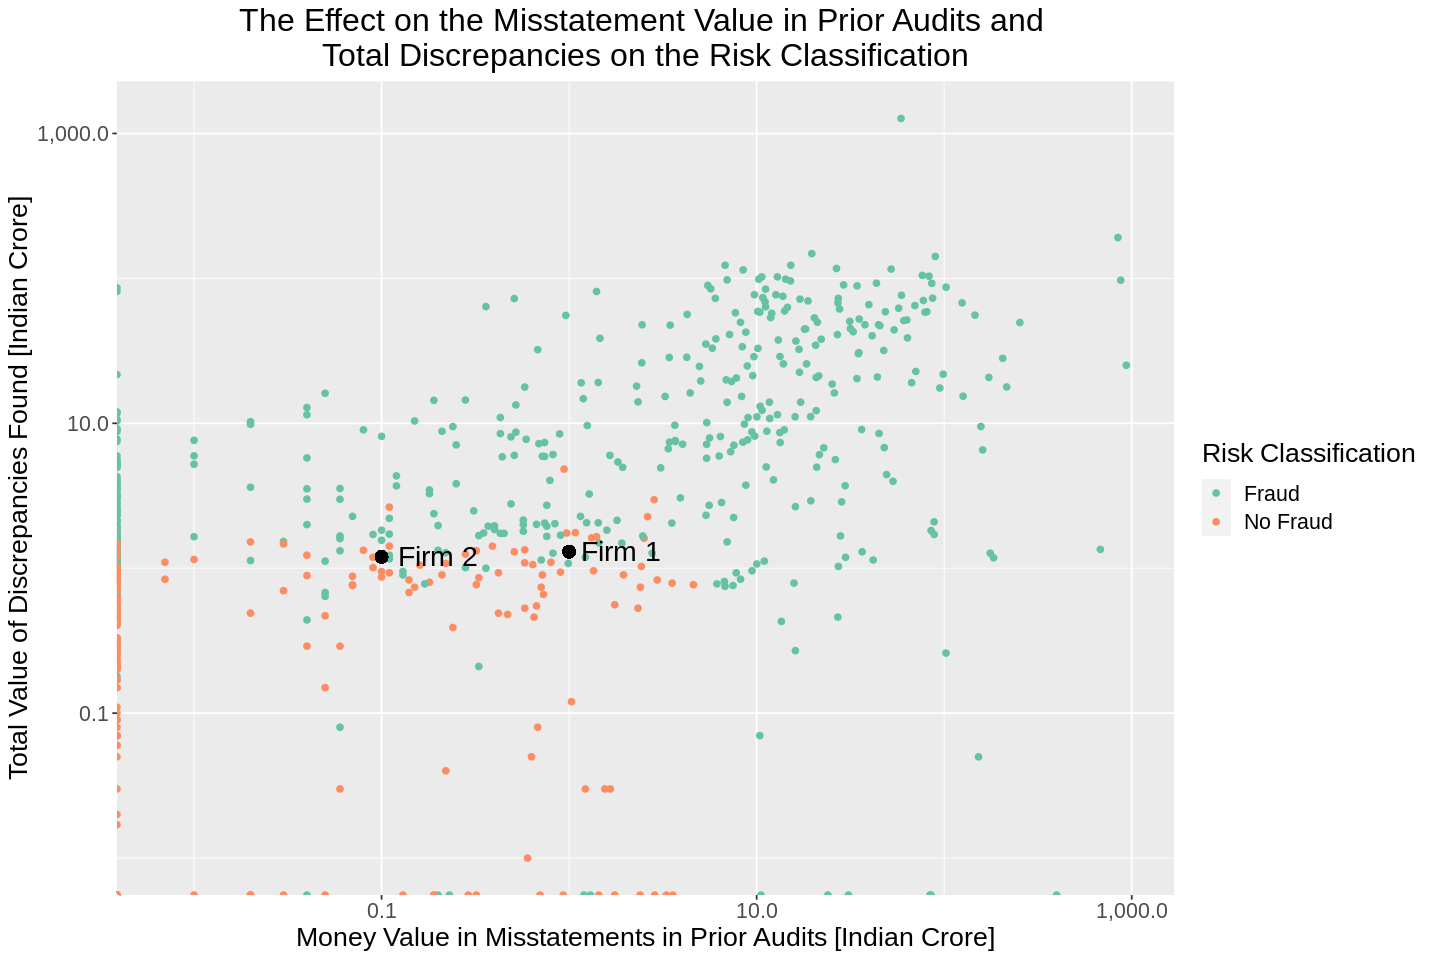

In [43]:
# Visualizing our model with two brand new supicious firms
audit_original_plot + 
    geom_point(aes(x = 1, y = 1.3), color = "black", size = 3) +
    geom_point(aes(x = 0.1, y = 1.2), color = "black", size = 3) +
    annotate("text", x = 1.9, y =  1.3, label = "Firm 1", size = 6) +
    annotate("text", x = 0.2, y =  1.2, label = "Firm 2", size = 6) 



In [41]:
?annotate

annotate {ggplot2},R Documentation
geom,name of geom to use for annotation
"x, y, xmin, ymin, xmax, ymax, xend, yend",positioning aesthetics - you must specify at least one of these.
...,"Other arguments passed on to layer(). These are often aesthetics, used to set an aesthetic to a fixed value, like colour = ""red"" or size = 3. They may also be parameters to the paired geom/stat."
na.rm,"If FALSE, the default, missing values are removed with a warning. If TRUE, missing values are silently removed."


In [27]:
# Testing our model with these two new firms
suspicious_1_prediction <- predict(audit_fit, suspicious_firm_1)
suspicious_2_prediction <- predict(audit_fit, suspicious_firm_2)
suspicious_1_prediction
suspicious_2_prediction

.pred_class
<fct>
No Fraud


.pred_class
<fct>
Fraud
